In [ ]:
# !pip install torch torchvision matplotlib --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create output directory for saving results
os.makedirs('output', exist_ok=True)

# Generator (U-Net)
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator (PatchGAN)
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Load dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize models
G = UNetGenerator(1, 1).to(device)
D = PatchDiscriminator(2).to(device)  # Input channels are 2 because we concatenate input and output images

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    for i, (real_A, _) in enumerate(train_loader):
        real_A = real_A.to(device)
        real_B = 1 - real_A  # Inverted version of the image
        real_AB = torch.cat((real_A, real_B), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        fake_B = G(real_A)
        fake_AB = torch.cat((real_A, fake_B), 1)
        D_real = D(real_AB)
        D_fake = D(fake_AB.detach())
        real_labels = torch.ones_like(D_real).to(device)
        fake_labels = torch.zeros_like(D_fake).to(device)
        loss_D_real = criterion_GAN(D_real, real_labels)
        loss_D_fake = criterion_GAN(D_fake, fake_labels)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        D_fake = D(fake_AB)
        loss_G_GAN = criterion_GAN(D_fake, real_labels)
        loss_G_L1 = criterion_L1(fake_B, real_B) * 100  # L1 loss for reconstruction
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{i+1}/{len(train_loader)}] '
                  f'Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}')

    # Save generated images for each epoch
    with torch.no_grad():
        fake_B = G(real_A)
        save_image(fake_B, f'output/generated_epoch_{epoch+1}.png', normalize=True)

print('Training complete.')

Epoch [1/1] Batch [100/1875] Loss D: 0.0010, Loss G: 98.8314
Epoch [1/1] Batch [200/1875] Loss D: 0.0004, Loss G: 94.9727
Epoch [1/1] Batch [300/1875] Loss D: 0.0002, Loss G: 96.7834
Epoch [1/1] Batch [400/1875] Loss D: 0.0001, Loss G: 96.8297
Epoch [1/1] Batch [500/1875] Loss D: 0.0001, Loss G: 97.2083
Epoch [1/1] Batch [600/1875] Loss D: 0.0001, Loss G: 97.7911
Epoch [1/1] Batch [700/1875] Loss D: 0.0001, Loss G: 95.2114
Epoch [1/1] Batch [800/1875] Loss D: 0.0000, Loss G: 95.4485
Epoch [1/1] Batch [900/1875] Loss D: 0.0000, Loss G: 97.1355
Epoch [1/1] Batch [1000/1875] Loss D: 0.0000, Loss G: 97.2939
Epoch [1/1] Batch [1100/1875] Loss D: 0.0000, Loss G: 97.3976
Epoch [1/1] Batch [1200/1875] Loss D: 0.0187, Loss G: 88.2238
Epoch [1/1] Batch [1300/1875] Loss D: 0.0010, Loss G: 90.9559
Epoch [1/1] Batch [1400/1875] Loss D: 0.0005, Loss G: 92.2663
Epoch [1/1] Batch [1500/1875] Loss D: 0.0003, Loss G: 93.2987
Epoch [1/1] Batch [1600/1875] Loss D: 0.0003, Loss G: 91.9929
Epoch [1/1] Batch

In [ ]:
# Load test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Function to save generated images
def save_generated_images(model, data_loader, device, num_images=16):
    model.eval()  # Set model to evaluation mode
    images_saved = 0

    with torch.no_grad():
        for i, (real_A, _) in enumerate(data_loader):
            real_A = real_A.to(device)
            fake_B = model(real_A)
            save_image(fake_B, f'output/test_generated_{i+1}.png', normalize=True)
            images_saved += 1
            if images_saved >= num_images:
                break

# Generate and save images
save_generated_images(G, test_loader, device)
print('Generated images have been saved to the output directory.')

Generated images have been saved to the output directory.


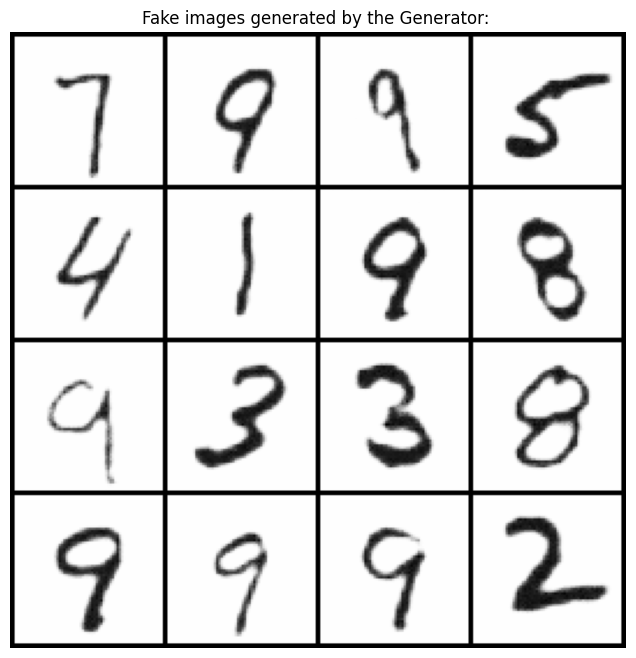

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display generated images
def display_generated_images(data_loader, num_images=8):
    data_iter = iter(data_loader)
    real_A, _ = next(data_iter)
    real_A = real_A.to(device)

    with torch.no_grad():
        fake_B = G(real_A)

    # Convert from tensor to numpy array and display
    grid_img = vutils.make_grid(fake_B.cpu(), nrow=4, normalize=True).permute(1, 2, 0).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img)
    plt.title("Fake images generated by the Generator: ")
    plt.axis('off')
    plt.show()

# Display images
display_generated_images(test_loader)

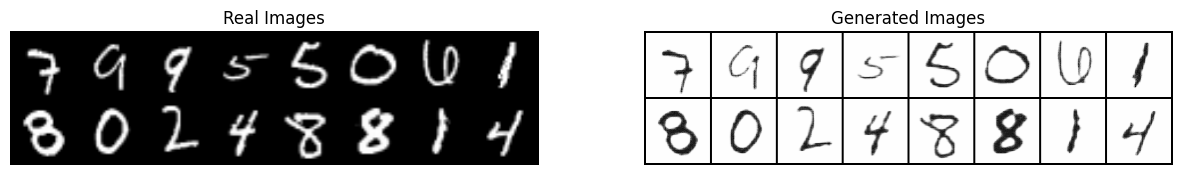

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display real and generated images side-by-side with labels
def display_real_and_generated_images(data_loader, model, device, num_images=8):
    model.eval()  # Set the model to evaluation mode
    data_iter = iter(data_loader)
    real_A, labels = next(data_iter)
    real_A = real_A.to(device)

    with torch.no_grad():
        fake_B = model(real_A)

    # Prepare the grid of real and fake images
    real_grid = vutils.make_grid(real_A.cpu(), nrow=num_images, normalize=True).permute(1, 2, 0).numpy()
    fake_grid = vutils.make_grid(fake_B.cpu(), nrow=num_images, normalize=True).permute(1, 2, 0).numpy()

    # Plot real images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(real_grid)
    plt.title("Real Images")
    plt.axis('off')

    # Plot fake images
    plt.subplot(1, 2, 2)
    plt.imshow(fake_grid)
    plt.title("Generated Images")
    plt.axis('off')
    plt.show()

# Display real and generated images with labels
display_real_and_generated_images(test_loader, G, device)